# Import Packages

In [12]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RepeatedKFold
from numpy import arange
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# Data Load & Feature Engineering

In [13]:
bpsell= pd.read_excel(r'D:\Users\91709\Downloads\Work\UpWork\2023-24\Gus\Data\BP SELLOUT Own Brands.xlsx', \
                      sheet_name= 'BP SELLOUT JAN TO SEP 2023- MAS')
bpinfo= pd.read_excel(r'D:\Users\91709\Downloads\Work\UpWork\2023-24\Gus\Data\BP Headcount_MASKED.xlsx')

bpsell= bpsell[bpsell['amount (in bottles)'] > 0 ]
bpsell= bpsell[bpsell['amount (in bottles)'].notnull()]

bpsell = bpsell.groupby('bp_id')['amount (in bottles)'].sum().reset_index()

bpinfo['Age'] = (pd.to_datetime('2023-09-30') - bpinfo['Date of Birth']).astype('<m8[Y]')
bpinfo['Tenure'] = (pd.to_datetime('2023-09-30') - bpinfo['Hire Date']).astype('<m8[Y]')

bpinfo= bpinfo[['Global Personnel ID', 'Nationality', 'Age', 'Tenure', 'Salary']]

data= bpsell.merge(bpinfo, how= 'inner', left_on= 'bp_id', right_on= 'Global Personnel ID')

data= data[['Nationality', 'Age', 'Tenure', 'Salary', 'amount (in bottles)']]

data = pd.get_dummies(data, columns=['Nationality'], prefix='Nationality')

# Correlation between Continous Variables + Nationality

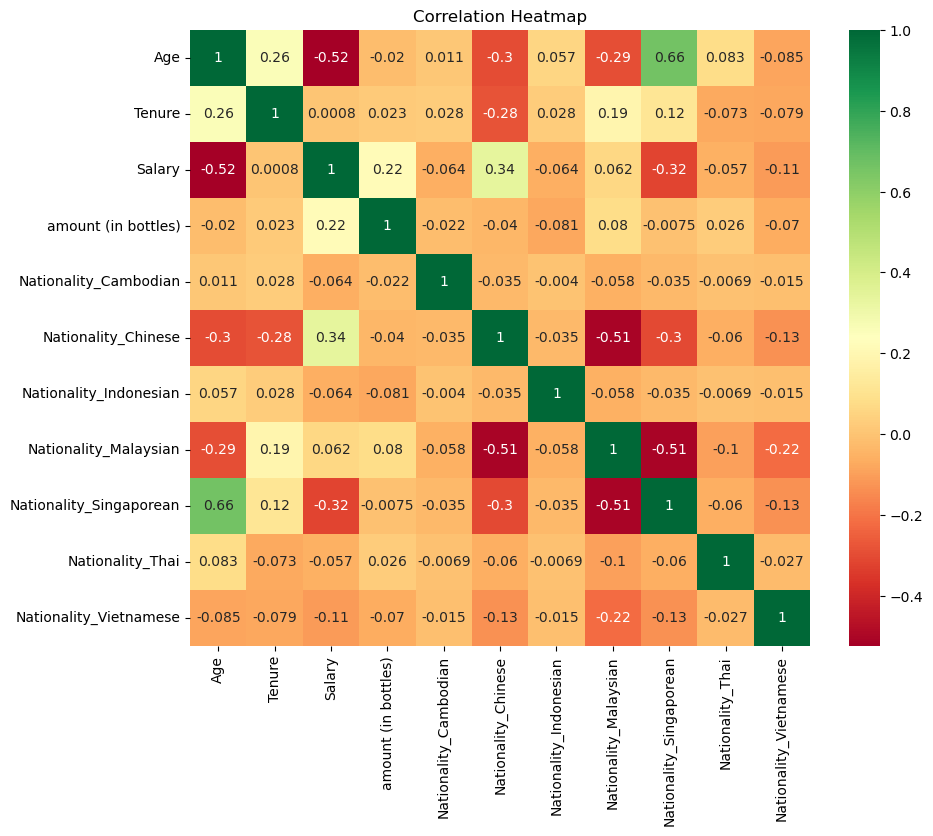

In [14]:
correlation_matrix= data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn')
plt.title('Correlation Heatmap')
plt.show()

# Lasso CV Continous Variables + Nationality

In [15]:
X = data.drop('amount (in bottles)', 1)
y = data['amount (in bottles)']

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

reg = LassoCV(alphas=arange(0, 1, 0.01), cv=cv, n_jobs=-1)
LassoCV()

reg.fit(X, y)

print('Best alpha using built-in LassoCV: %f' % reg.alpha_)
print('R2: %f' % reg.score(X,y))
print('Adjusted R2: %f' % (1 - (1-reg.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)))
y_predicted = reg.predict(X)
print('RMSE: %f' % (mean_squared_error(y, y_predicted, squared=False)))
print('y intercept of the model: %f' % reg.intercept_)
coef = pd.Series(reg.coef_, index = X.columns)
print('Lasso picked ' + str(sum(coef != 0)) + ' variables and eliminated the other ' + str(sum(coef == 0)) + ' variables')
coef = coef[coef !=0]
imp_coef = coef.sort_values(ascending = False)
print(imp_coef)

Best alpha using built-in LassoCV: 0.990000
R2: 0.080713
Adjusted R2: 0.042726
RMSE: 9505.998632
y intercept of the model: -4786.826065
Lasso picked 9 variables and eliminated the other 1 variables
Nationality_Thai            2784.408002
Nationality_Malaysian       1522.933211
Nationality_Singaporean      290.881017
Age                          134.673867
Salary                        11.923413
Tenure                      -128.272153
Nationality_Vietnamese      -741.091356
Nationality_Chinese        -1785.028660
Nationality_Indonesian    -10084.991226
dtype: float64


# Random Forest Continous Variables + Nationality

R2: 0.790334
Adjusted R2: 0.781670
RMSE: 4539.796695
Feature Importances:
                   Feature  Importance
2                   Salary    0.348719
0                      Age    0.341742
1                   Tenure    0.224793
4      Nationality_Chinese    0.031562
6    Nationality_Malaysian    0.027269
7  Nationality_Singaporean    0.013373
9   Nationality_Vietnamese    0.006151
5   Nationality_Indonesian    0.003193
8         Nationality_Thai    0.003080
3    Nationality_Cambodian    0.000118


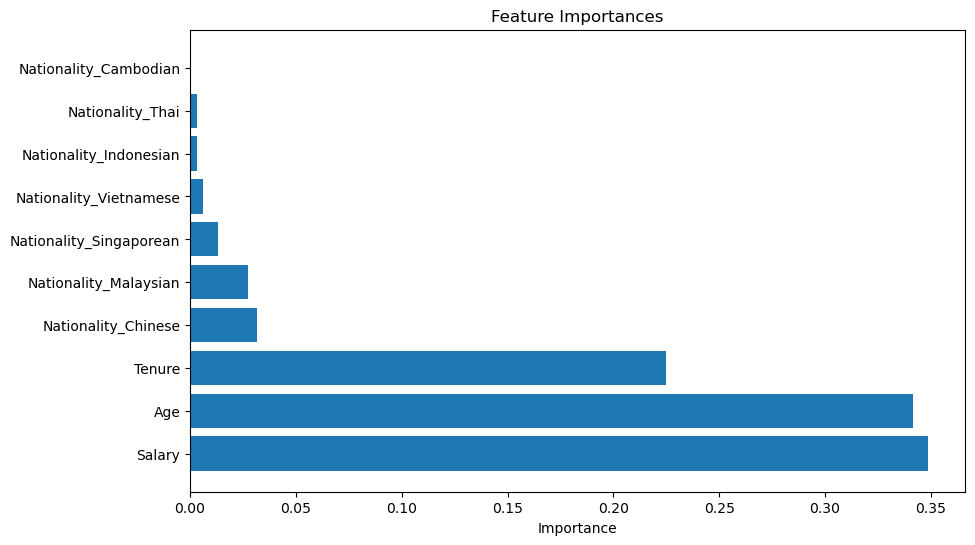

In [16]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

rf.fit(X,y)

predictions = rf.predict(X)

print('R2: %f' % rf.score(X,y))
print('Adjusted R2: %f' % (1 - (1-rf.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)))
print('RMSE: %f' % (mean_squared_error(y, predictions, squared=False)))

feature_importances = rf.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

# Gradient Boost Continous Variables + Nationality

R2: 0.610603
Adjusted R2: 0.594513
RMSE: 6186.830773
Feature Importances:
                   Feature  Importance
2                   Salary    0.428549
0                      Age    0.298388
1                   Tenure    0.229411
4      Nationality_Chinese    0.023553
5   Nationality_Indonesian    0.006137
6    Nationality_Malaysian    0.005545
9   Nationality_Vietnamese    0.005156
8         Nationality_Thai    0.003228
7  Nationality_Singaporean    0.000034
3    Nationality_Cambodian    0.000000


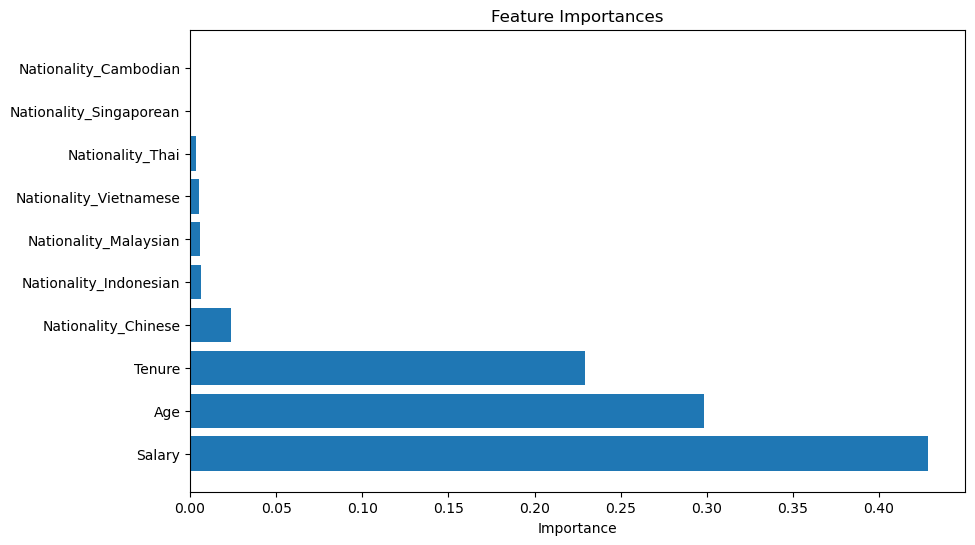

In [17]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

gb_model.fit(X, y)

predictions = gb_model.predict(X)

print('R2: %f' % gb_model.score(X,y))
print('Adjusted R2: %f' % (1 - (1-gb_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)))
print('RMSE: %f' % (mean_squared_error(y, predictions, squared=False)))

feature_importances = gb_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

# Convert Continous Variables into Categorical with Bins

In [18]:
age_bin= [18, 25, 35, 45, 55, 65, float('inf') ]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

data['Age_Bins'] = pd.cut(data['Age'], bins=age_bin, labels=age_labels)

tenure_bin= [-1, 3, 6, 11, 15, float('inf')]
tenure_labels = ['0-2', '3-5', '6-10', '11-15', '15+']

data['Tenure_Bins'] = pd.cut(data['Tenure'], bins=tenure_bin, labels=tenure_labels)

salary_bin= [1000, 1201, 1401, 1601, 1801, float('inf')]
salary_labels = ['1000-1200', '1201-1400', '1401-1600', '1601-1800', '1800+']

data['Salary_Bins'] = pd.cut(data['Salary'], bins=salary_bin, labels=salary_labels)

data_transform = data.drop(['Age', 'Tenure','Salary'], axis=1)


data_transform = pd.get_dummies(data_transform, columns=['Salary_Bins'], prefix='Salary')
data_transform = pd.get_dummies(data_transform, columns=['Age_Bins'], prefix='Age')
data_transform = pd.get_dummies(data_transform, columns=['Tenure_Bins'], prefix='Tenure')

# Correlation Categorical Variables

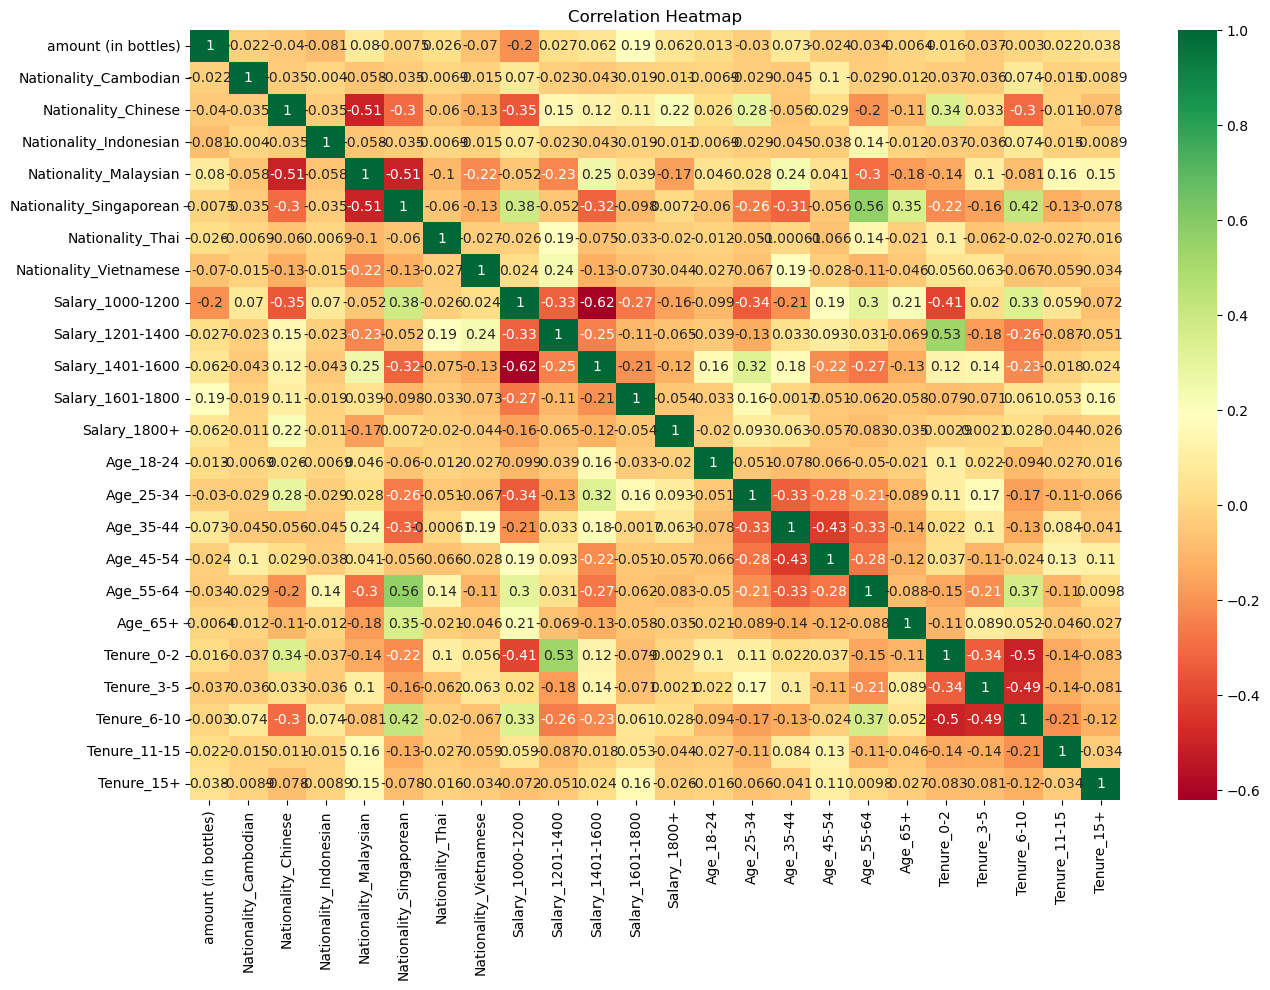

In [19]:
correlation_matrix= data_transform.corr()

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn')
plt.title('Correlation Heatmap')
plt.show()

# Lasso CV Categorical Variables

In [20]:
X = data_transform.drop('amount (in bottles)', 1)
y = data_transform['amount (in bottles)']

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

reg = LassoCV(alphas=arange(0, 1, 0.01), cv=cv, n_jobs=-1)
LassoCV()

reg.fit(X, y)

print('Best alpha using built-in LassoCV: %f' % reg.alpha_)
print('R2: %f' % reg.score(X,y))
print('Adjusted R2: %f' % (1 - (1-reg.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)))
y_predicted = reg.predict(X)
print('RMSE: %f' % (mean_squared_error(y, y_predicted, squared=False)))
print('y intercept of the model: %f' % reg.intercept_)
coef = pd.Series(reg.coef_, index = X.columns)
print('Lasso picked ' + str(sum(coef != 0)) + ' variables and eliminated the other ' + str(sum(coef == 0)) + ' variables')
coef = coef[coef !=0]
imp_coef = coef.sort_values(ascending = False)
print(imp_coef)

Best alpha using built-in LassoCV: 0.990000
R2: 0.102472
Adjusted R2: 0.012327
RMSE: 9392.825406
y intercept of the model: 17460.071998
Lasso picked 19 variables and eliminated the other 4 variables
Salary_1601-1800           5696.833204
Salary_1800+               3770.138164
Nationality_Thai           2981.295944
Nationality_Singaporean    1957.716856
Nationality_Malaysian      1730.552519
Age_65+                    1253.058280
Tenure_11-15                530.065025
Age_45-54                   147.069085
Tenure_3-5                   59.641236
Tenure_0-2                  -68.357386
Age_35-44                  -212.852074
Salary_1201-1400           -362.910080
Age_18-24                  -766.593717
Nationality_Vietnamese    -1218.947774
Nationality_Chinese       -1332.000249
Tenure_15+                -1656.557575
Age_25-34                 -2935.270630
Salary_1000-1200          -4913.206299
Nationality_Indonesian    -8860.475051
dtype: float64


# Random Forest Categorical Variables

R2: 0.331491
Adjusted R2: 0.264348
RMSE: 8106.361286
Feature Importances:
                    Feature  Importance
19               Tenure_3-5    0.100951
10         Salary_1601-1800    0.090670
7          Salary_1000-1200    0.085687
13                Age_25-34    0.082295
14                Age_35-44    0.073894
20              Tenure_6-10    0.069671
1       Nationality_Chinese    0.057880
3     Nationality_Malaysian    0.054555
9          Salary_1401-1600    0.050651
16                Age_55-64    0.047693
18               Tenure_0-2    0.045285
11             Salary_1800+    0.040423
21             Tenure_11-15    0.038147
15                Age_45-54    0.036954
4   Nationality_Singaporean    0.031557
12                Age_18-24    0.027403
8          Salary_1201-1400    0.016477
17                  Age_65+    0.014841
6    Nationality_Vietnamese    0.014523
2    Nationality_Indonesian    0.008280
22               Tenure_15+    0.006636
5          Nationality_Thai    0.005127
0     

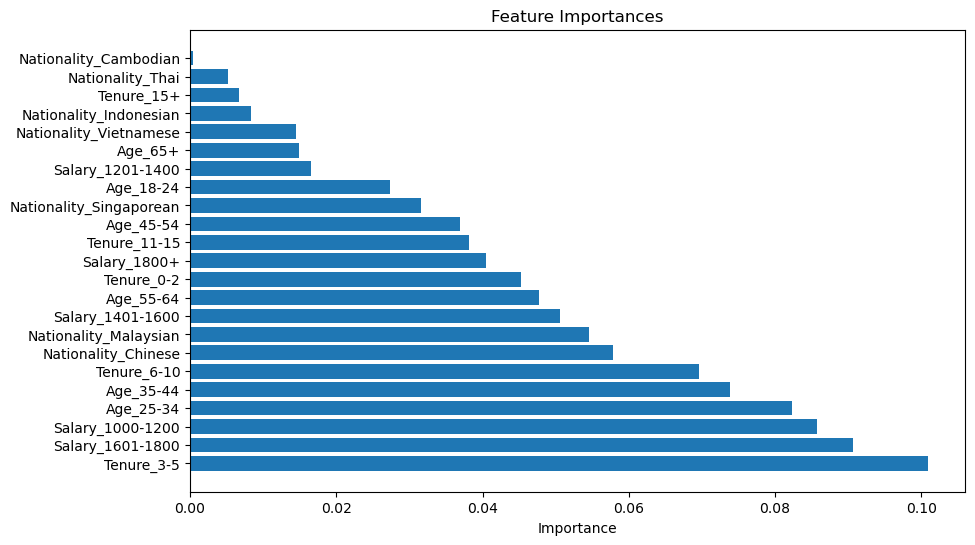

In [21]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

rf.fit(X,y)

predictions = rf.predict(X)

print('R2: %f' % rf.score(X,y))
print('Adjusted R2: %f' % (1 - (1-rf.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)))
print('RMSE: %f' % (mean_squared_error(y, predictions, squared=False)))

feature_importances = rf.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

# Gradient Boost Categorical Variables

R2: 0.290465
Adjusted R2: 0.219202
RMSE: 8351.395026
Feature Importances:
                    Feature  Importance
7          Salary_1000-1200    0.139951
10         Salary_1601-1800    0.100246
1       Nationality_Chinese    0.091886
20              Tenure_6-10    0.086702
13                Age_25-34    0.086682
19               Tenure_3-5    0.076236
14                Age_35-44    0.072835
16                Age_55-64    0.053061
9          Salary_1401-1600    0.050313
21             Tenure_11-15    0.042929
12                Age_18-24    0.041510
3     Nationality_Malaysian    0.034665
15                Age_45-54    0.027730
4   Nationality_Singaporean    0.024439
11             Salary_1800+    0.017625
6    Nationality_Vietnamese    0.015607
2    Nationality_Indonesian    0.015484
18               Tenure_0-2    0.010648
8          Salary_1201-1400    0.004587
17                  Age_65+    0.002524
5          Nationality_Thai    0.002049
22               Tenure_15+    0.001630
0     

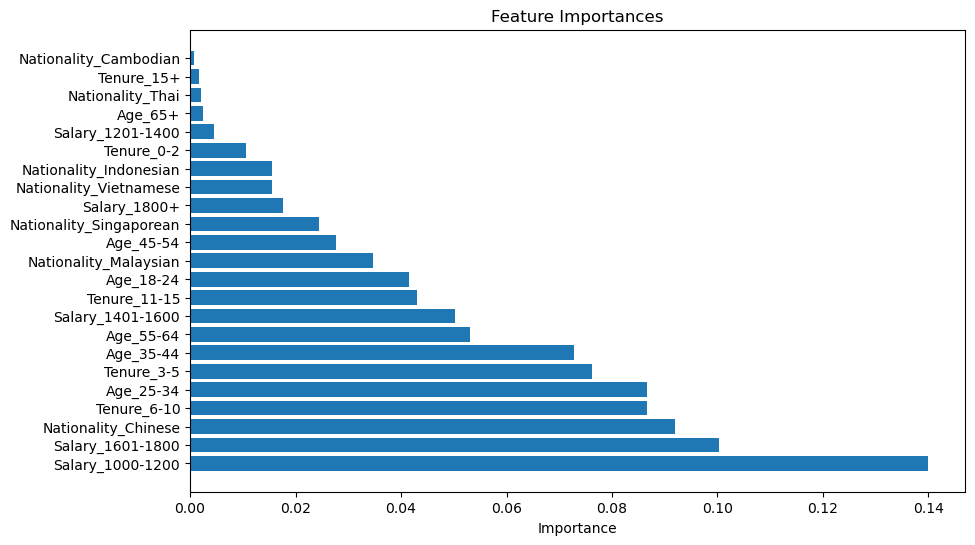

In [22]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

gb_model.fit(X, y)

predictions = gb_model.predict(X)

print('R2: %f' % gb_model.score(X,y))
print('Adjusted R2: %f' % (1 - (1-gb_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)))
print('RMSE: %f' % (mean_squared_error(y, predictions, squared=False)))

feature_importances = gb_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()